In [ ]:
import pandas as pd
import seaborn as sns
import numpy as nb

In [ ]:
df = pd.read_csv("features/features.csv")

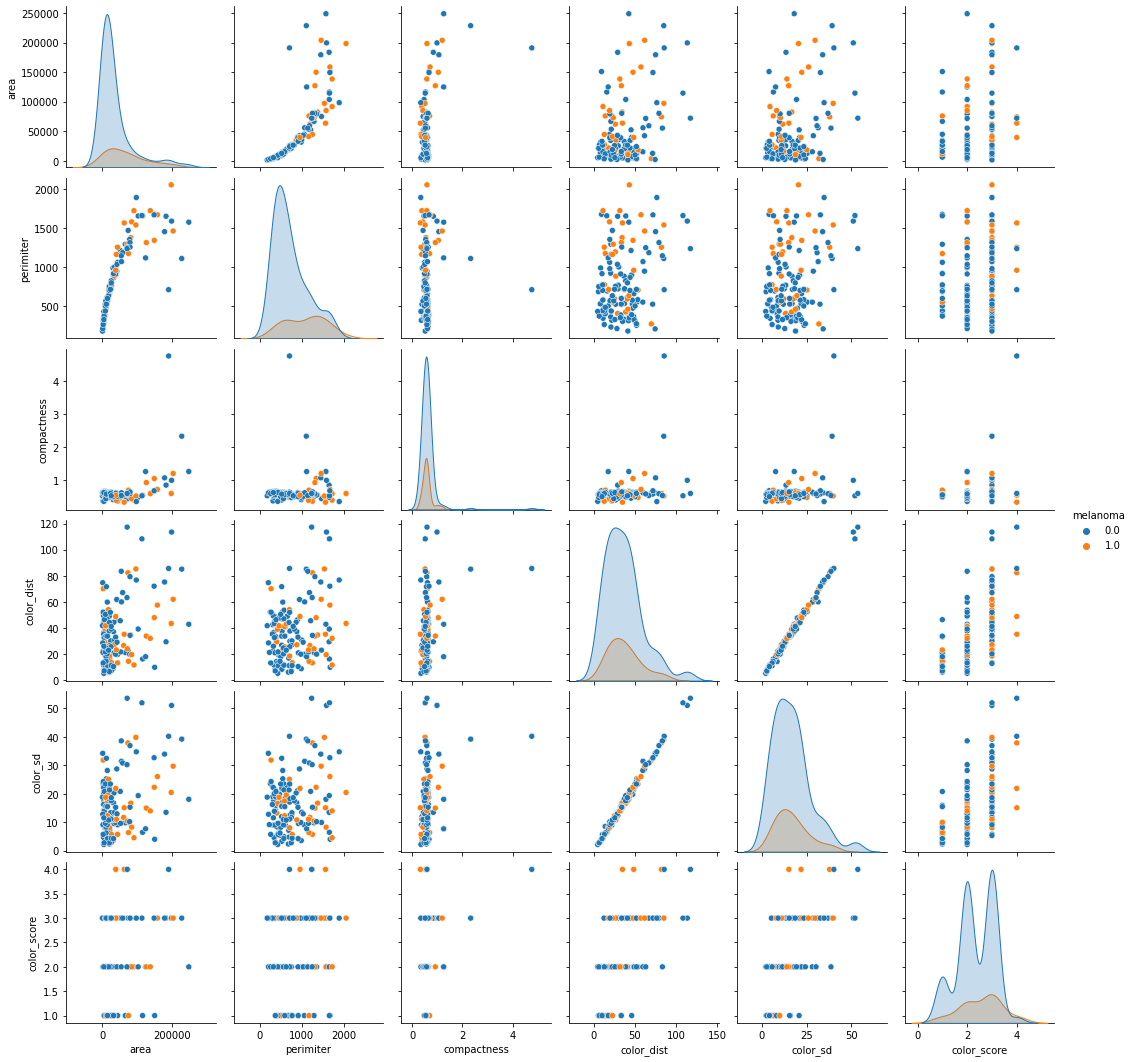

In [ ]:
sns.pairplot(data=df, hue="melanoma", diag_kind="kde")

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6840a14b-d41a-45b9-abd0-892354334cb2' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>